In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings
warnings.filterwarnings(action="ignore")

# Preprocessing Libraries

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Machine Learning Libraries
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

df = pd.read_csv('https://raw.githubusercontent.com/shreddedScientist/MSDS422-Practical-Machine-Learning/main/data.csv')


# Data Cleaning and Preprocessing

In [2]:
#there are no null values
df.isnull().sum().sort_values(ascending=False).head()

 Equity to Liability                 0
 Net Income Flag                     0
 Operating Profit Growth Rate        0
 After-tax Net Profit Growth Rate    0
 Regular Net Profit Growth Rate      0
dtype: int64

In [3]:
#checking for duplicates, there are none
df.duplicated().sum()

0

# EDA

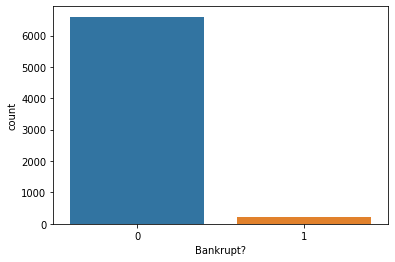

In [4]:
sns.countplot('Bankrupt?',data=df)

In [5]:
#There were 220 businesses bankrupt, and 6,599 that were not.
#this means that even if you had assumed all of them were not bankrupt,
#you would still have an accuracy score of 96.77%, therefore anything below
#that would mean your model is not really of use

pd.crosstab(df['Bankrupt?']==0,df['Bankrupt?']==1)

Bankrupt?,False,True
Bankrupt?,,
False,6599,0
True,0,220


In [6]:
#Create numeric datasets

numeric = df.select_dtypes(include=['number', 'int32','int64','float64']).columns
num_df = df[numeric]


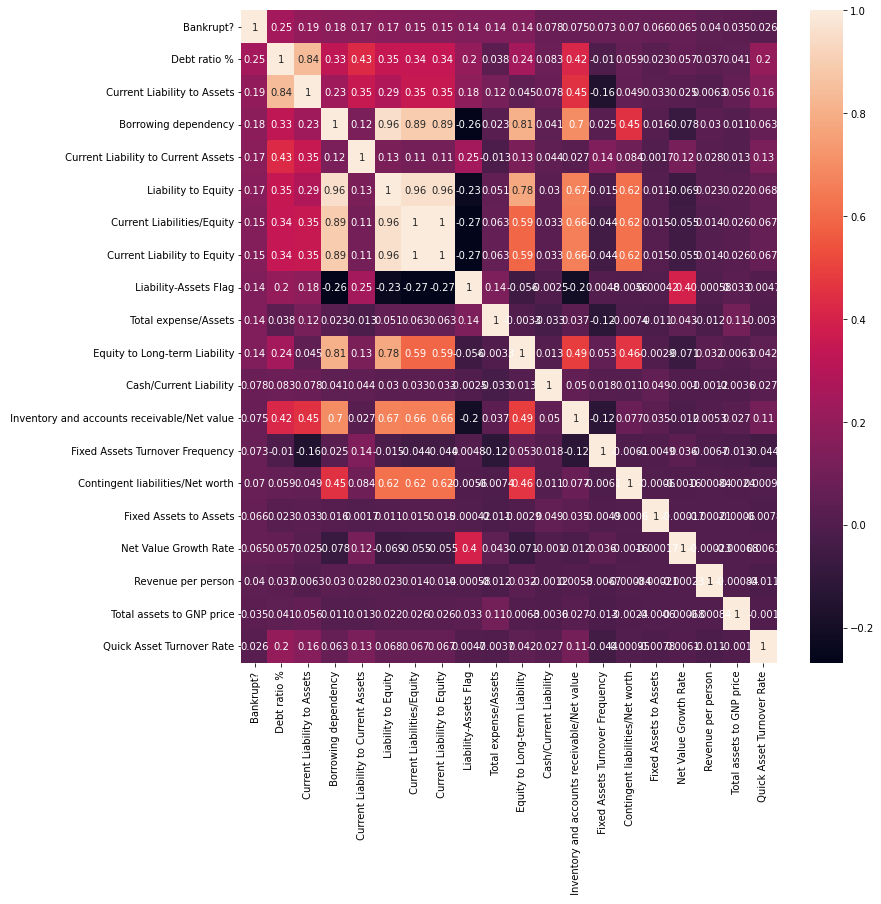

In [7]:
#correlation heatmap of the strongest correlations
corrmat = num_df.corr()

num_strong_corr = corrmat.nlargest(20, 'Bankrupt?')['Bankrupt?'].index
num_strong_corr

#We create a new correlation heatmap to look at those only
num_corrmat = np.corrcoef(num_df[num_strong_corr].values.T)
fix, ax = plt.subplots(figsize=(12,12))
sns.heatmap(num_corrmat, annot=True, xticklabels = num_strong_corr.values,
            yticklabels = num_strong_corr.values)
plt.show()

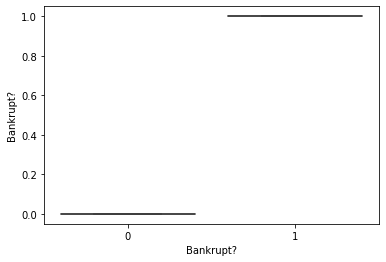

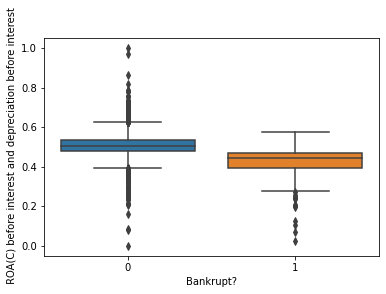

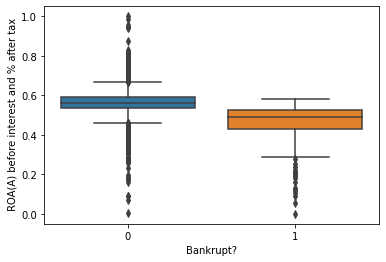

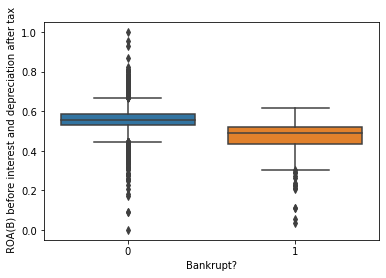

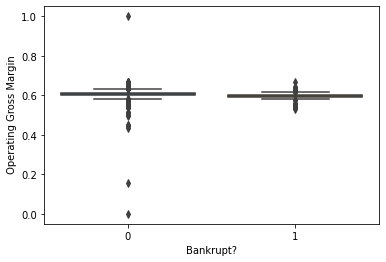

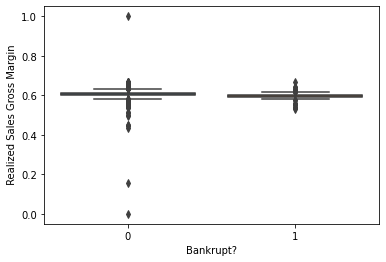

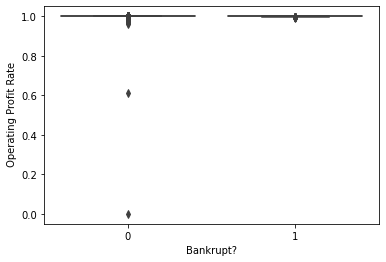

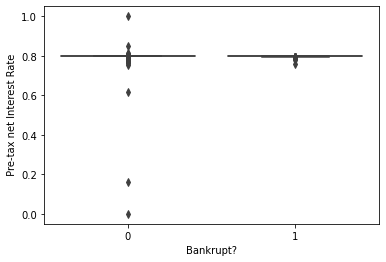

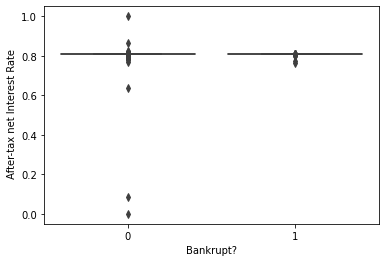

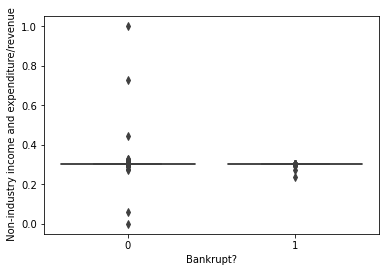

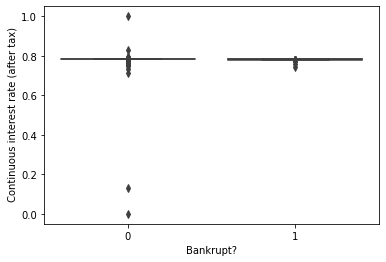

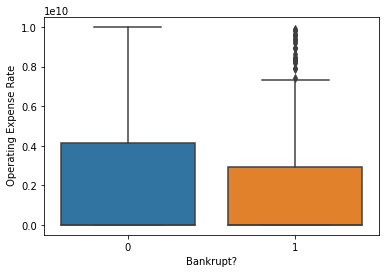

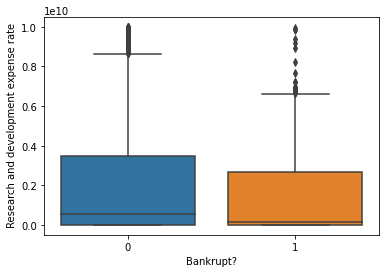

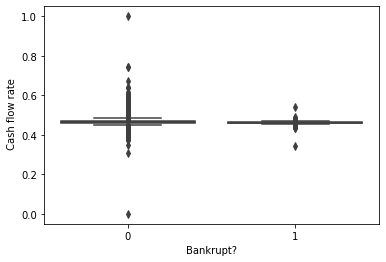

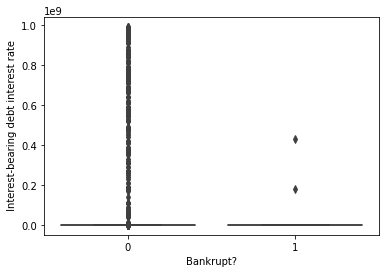

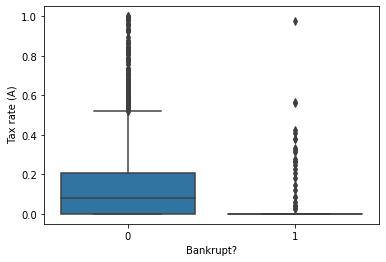

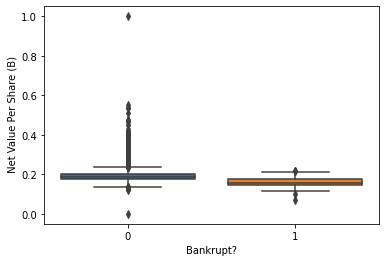

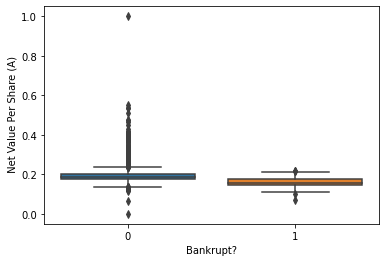

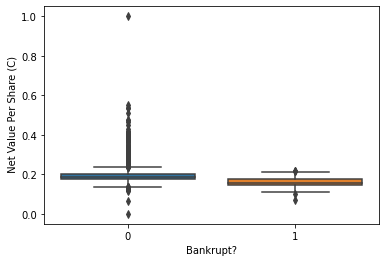

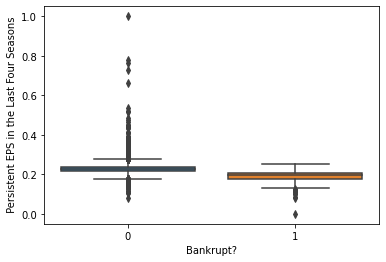

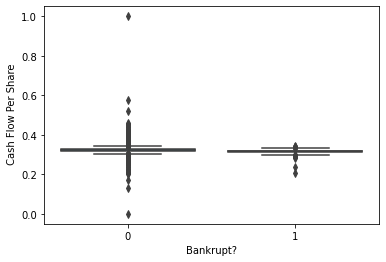

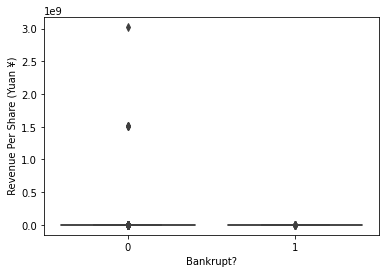

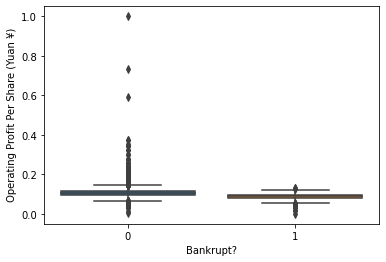

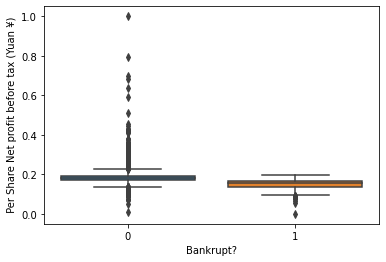

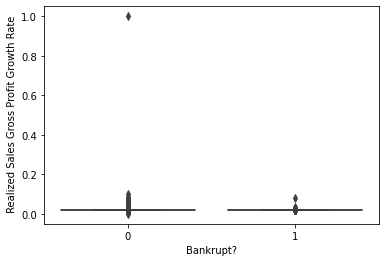

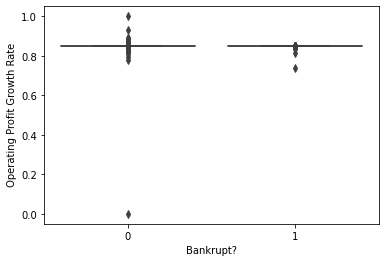

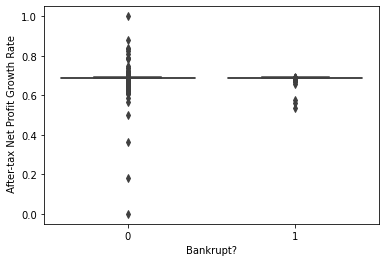

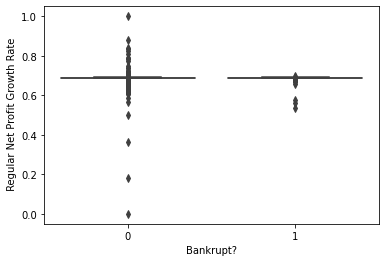

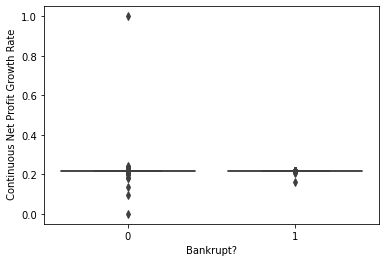

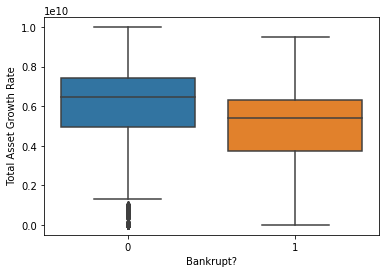

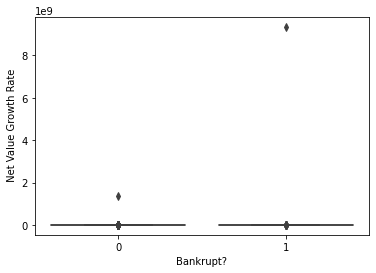

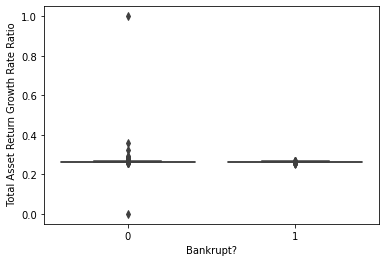

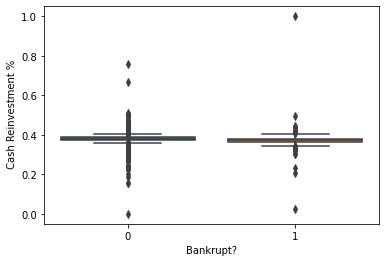

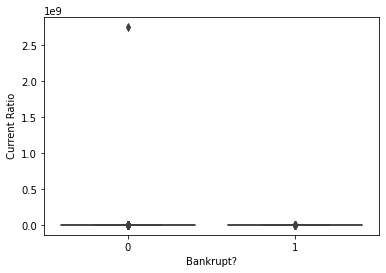

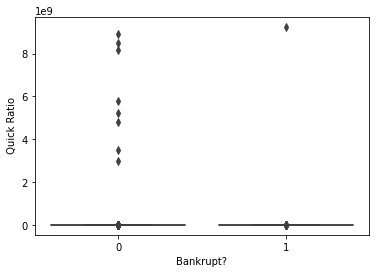

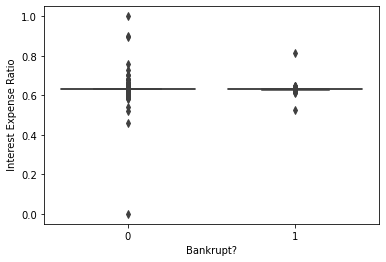

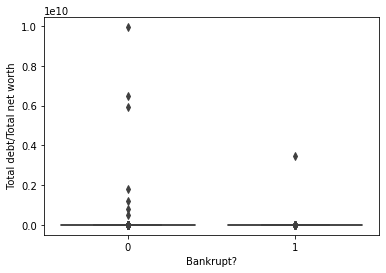

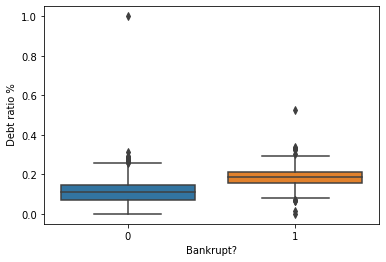

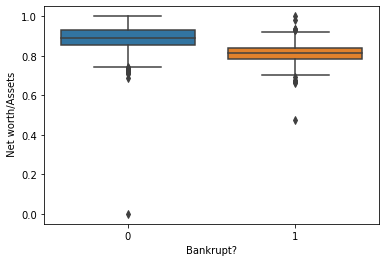

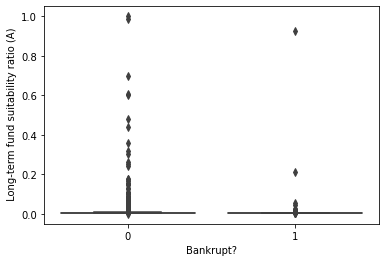

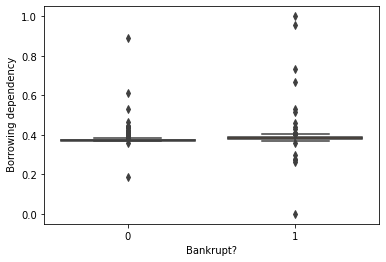

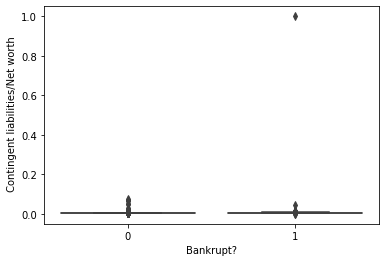

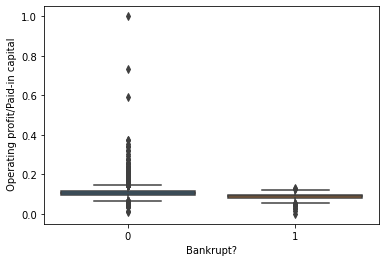

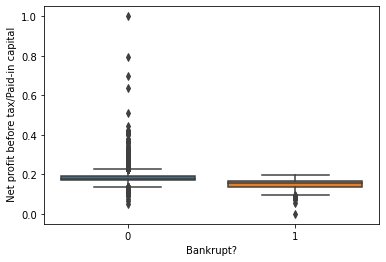

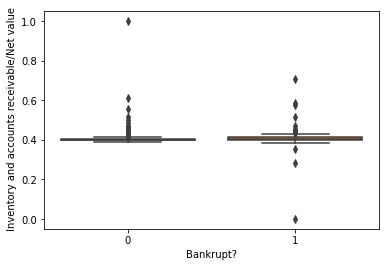

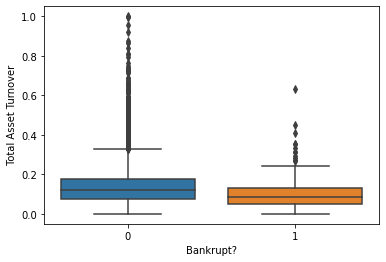

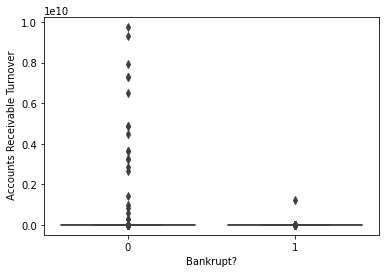

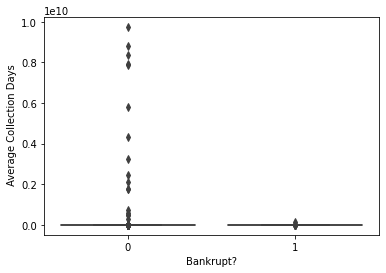

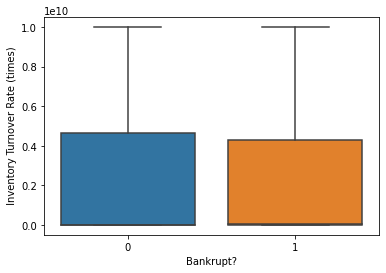

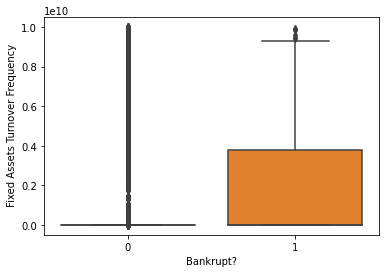

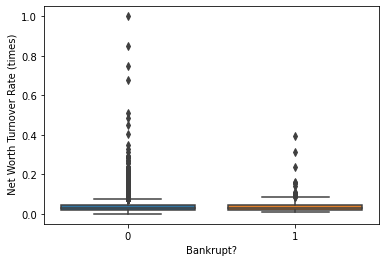

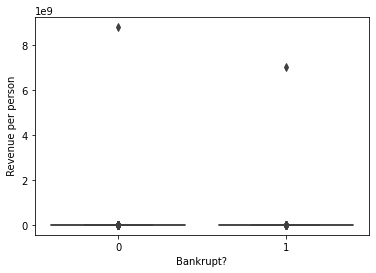

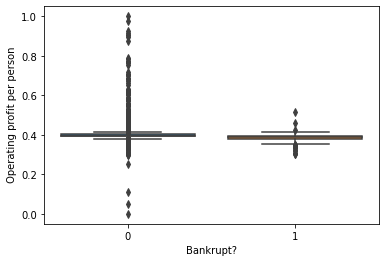

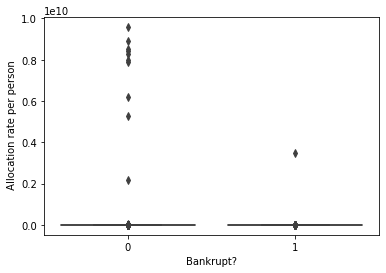

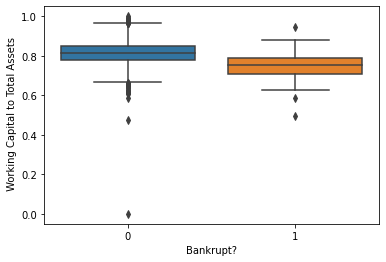

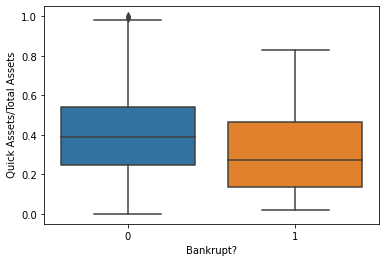

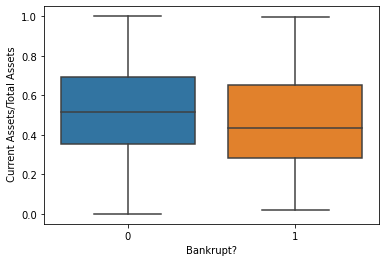

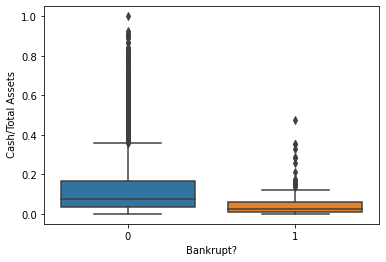

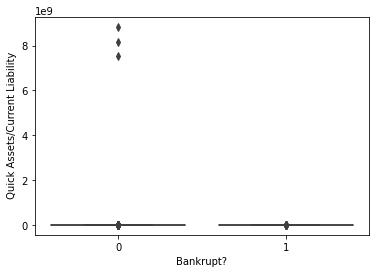

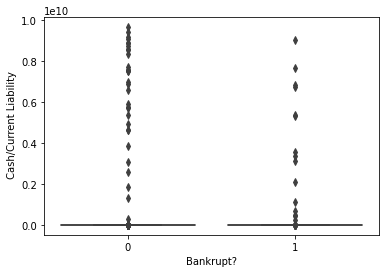

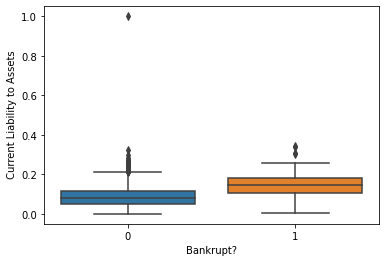

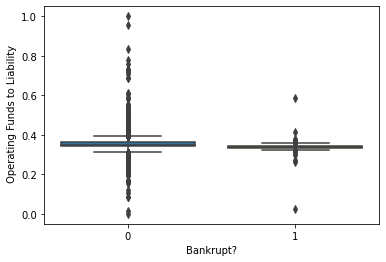

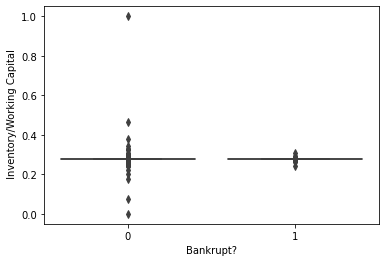

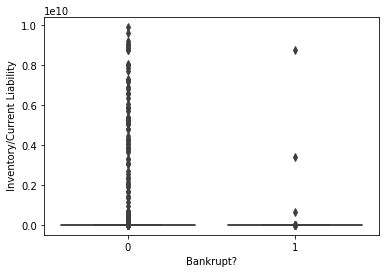

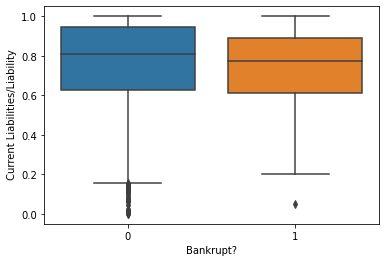

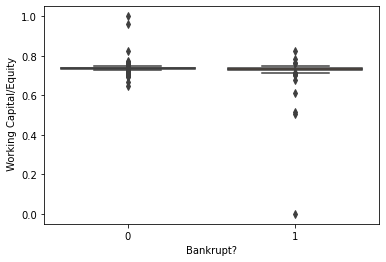

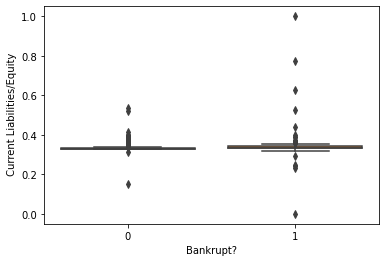

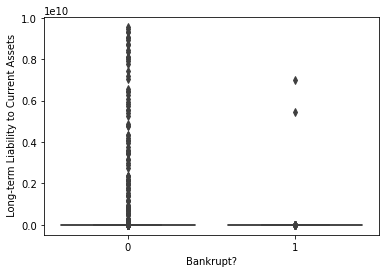

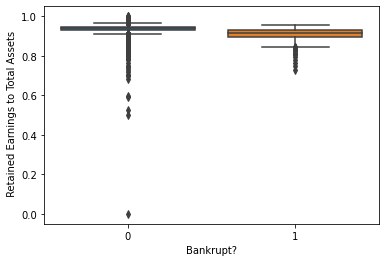

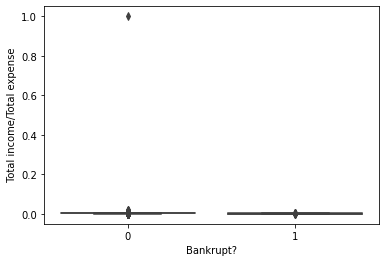

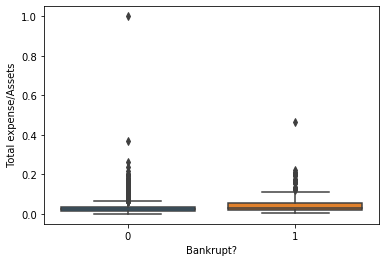

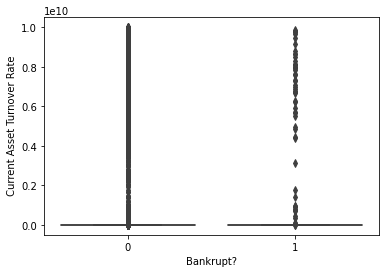

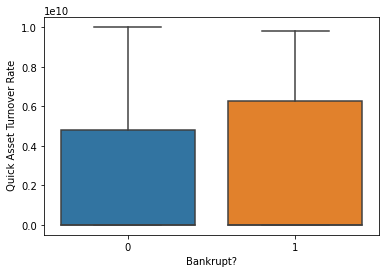

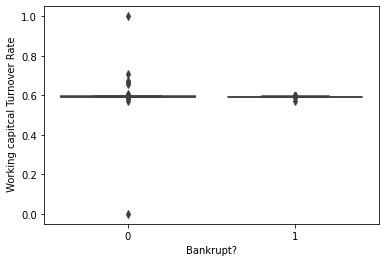

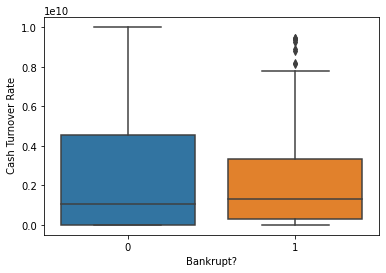

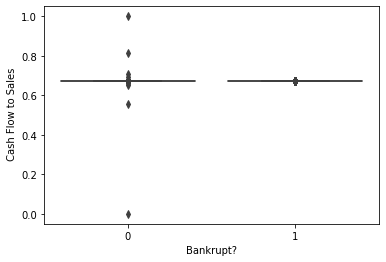

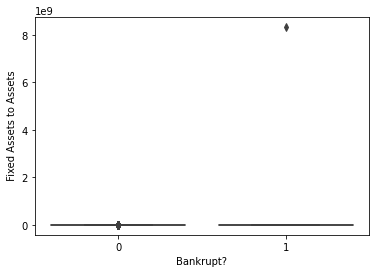

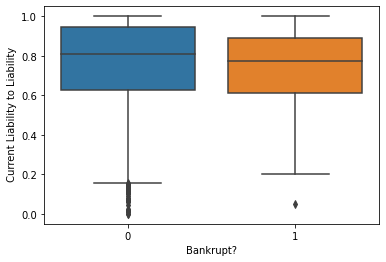

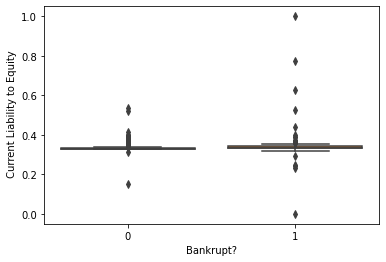

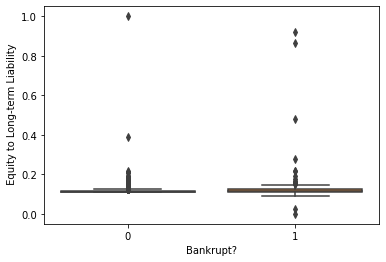

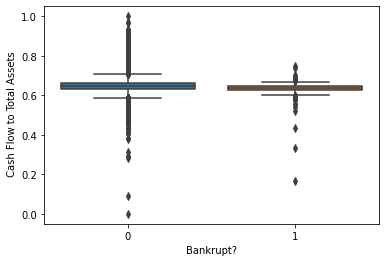

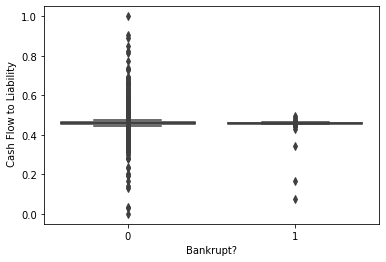

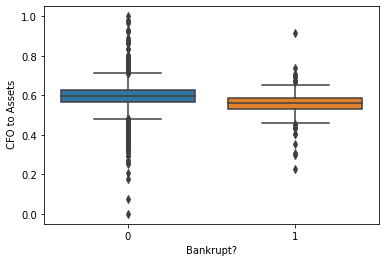

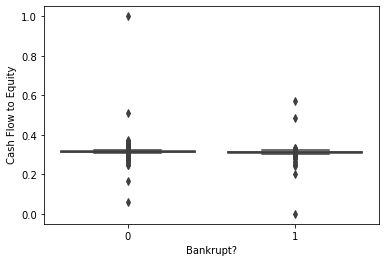

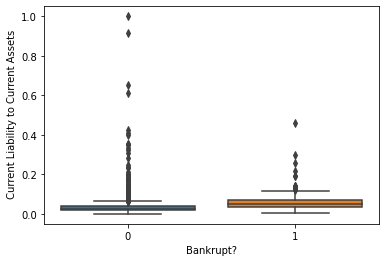

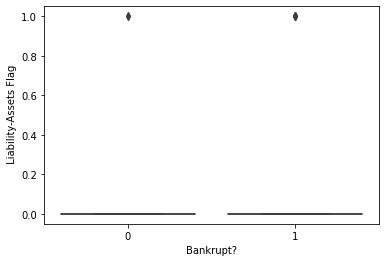

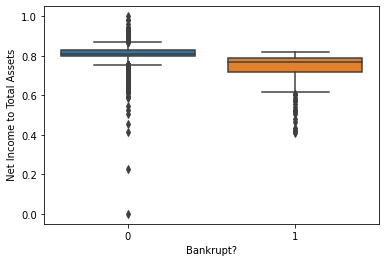

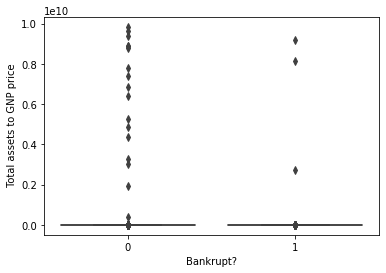

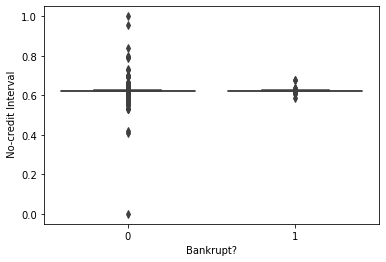

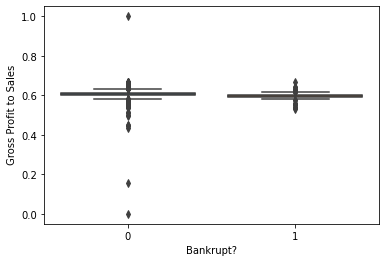

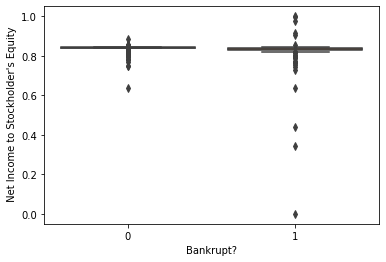

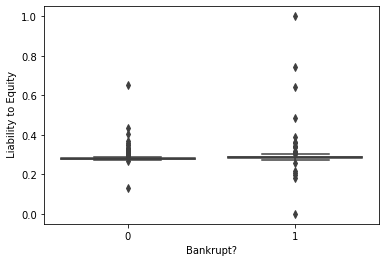

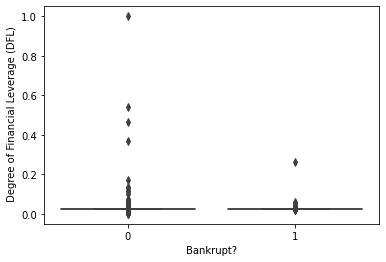

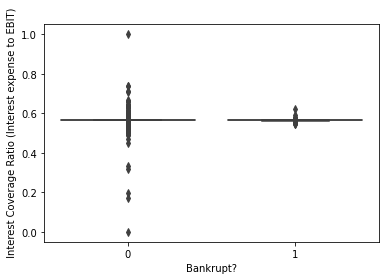

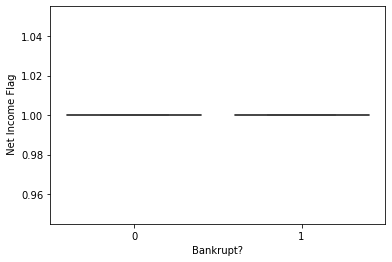

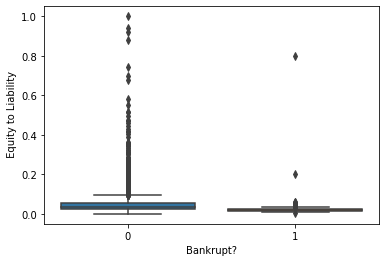

In [8]:
#plotting all numeric features through a for loop

for column in numeric:
    fig, ax = plt.subplots()
    sns.boxplot(y=column, data = df, x = 'Bankrupt?')

plt.show()

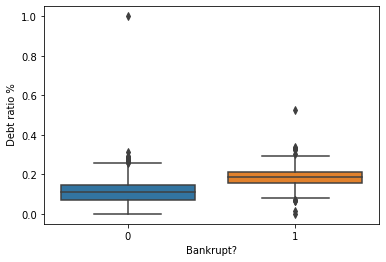

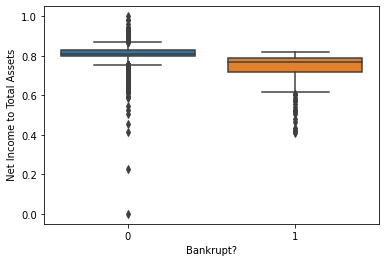

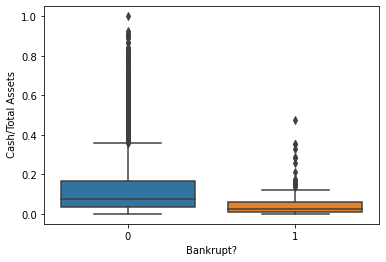

In [9]:
# Plotting possible strong predictors

sns.boxplot(x='Bankrupt?', y=" Debt ratio %", data=df)
plt.show()
sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=df)
plt.show()
sns.boxplot(x='Bankrupt?', y=" Cash/Total Assets", data=df)
plt.show()

# Preparation for ML Models

In [10]:
# Dividing Data and Labels

labels = df['Bankrupt?']
df = df.drop(['Bankrupt?'], axis = 1) #x

In [11]:
#Creating normalized dataset dataframe

def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

data_norm = log_trans(df)

In [12]:
# Splitting Train and Test Data

X_raw,X_test,y_raw,y_test  = train_test_split(df,
                                              labels,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)

In [15]:
# Stratified Cross Validation Splitting

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)


In [16]:
sm = SMOTE(random_state = 42)

# SMOTE training set
X_smote, y_smote = sm.fit_resample(X_raw, y_raw)

print(f"Percent (SMOTE) training data bankrupt: {sum(y_smote) / len(X_smote)}")
print(f"Percent (SMOTE) testing data bankrupt: {sum(y_test) / len(X_test)}")

Percent (SMOTE) training data bankrupt: 0.5
Percent (SMOTE) testing data bankrupt: 0.03225806451612903


# Logistic Regression

In [17]:
# List to append the score and then find the average

accuracy_list_reg = []
precision_list_reg = []
recall_list_reg = []
f1_list_reg = []
auc_list_reg = []

log_reg_sm = LogisticRegression()
#log_reg_params = {}
log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, val in sss.split(X_smote, y_smote):
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation
    model_reg = pipeline_reg.fit(X_smote[train], y_smote[train])
    best_est_reg = rand_log_reg.best_estimator_
    prediction_reg = best_est_reg.predict(X_smote[val])
    
    accuracy_list_reg.append(pipeline_reg.score(X_smote[val], y_smote[val]))
    precision_list_reg.append(precision_score(y_smote[val], prediction_reg))
    recall_list_reg.append(recall_score(y_smote[val], prediction_reg))
    f1_list_reg.append(f1_score(y_smote[val], prediction_reg))
    auc_list_reg.append(roc_auc_score(y_smote[val], prediction_reg))


print('Logistic Regression (SMOTE) results:\n')
print("accuracy: ",np.mean(accuracy_list_reg))
print("precision: ",np.mean(precision_list_reg))
print("recall: ",np.mean(recall_list_reg))
print("f1: ",np.mean(f1_list_reg))


Logistic Regression (SMOTE) results:

accuracy:  0.8932569567058554
precision:  0.8749126944961796
recall:  0.9179753698118628
f1:  0.8958997598824967


In [18]:
# Printing the classification report

label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_test)
print(classification_report(y_test, pred_reg_sm, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.91      0.95      1320
Fin.Unstable       0.22      0.80      0.34        44

    accuracy                           0.90      1364
   macro avg       0.61      0.85      0.65      1364
weighted avg       0.97      0.90      0.93      1364



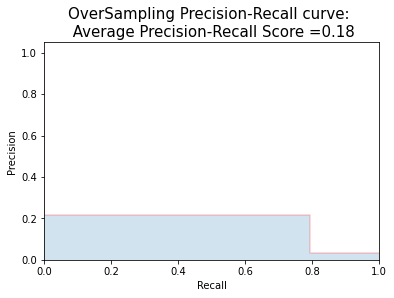

In [19]:
# Plotting Precision-Recall curve

y_score_reg = best_est_reg.predict(X_test)

average_precision = average_precision_score(y_test, y_score_reg)

precision, recall, _ = precision_recall_curve(y_test, y_score_reg)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=15)

plt.show()


# Support Vector Machine

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

from sklearn.svm import SVC
from sklearn import metrics
svc=SVC() #Default hyperparameters
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))



Accuracy Score:
0.9626099706744868


In [21]:
print(classification_report(y_test, y_pred, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.96      1.00      0.98      1313
Fin.Unstable       0.00      0.00      0.00        51

    accuracy                           0.96      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.96      0.94      1364



# Naive Bayes

In [22]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA

df = pd.read_csv('https://raw.githubusercontent.com/shreddedScientist/MSDS422-Practical-Machine-Learning/main/data.csv')



In [23]:
numeric = df.select_dtypes(include=['number', 'int32','int64','float64']).columns
num_df = df[numeric]

labelNB = df['Bankrupt?']
df2 = df.drop(['Bankrupt?'], axis = 1)


In [24]:
#X_train, X_test, y_train, y_test = train_test_split(df2, labelNB, test_size = 0.2, random_state = 0)

In [25]:
#X_train.shape, X_test.shape


In [26]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB



In [27]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
y_pred = gnb.predict(X_test)
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [29]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.6136


In [30]:
y_pred_train = gnb.predict(X_train)

y_pred_train

array([1, 0, 0, ..., 0, 0, 0])

In [31]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[792 521]
 [  6  45]]

True Positives(TP) =  792

True Negatives(TN) =  45

False Positives(FP) =  521

False Negatives(FN) =  6


# Random Forest Classifier

In [32]:
#creating a list of metrics

accuracy_list_rfc = []
precision_list_rfc = []
recall_list_rfc = []
f1_list_rfc = []
auc_list_rfc = []

rfc_sm = RandomForestClassifier()

rfc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}

In [33]:
#Using randomized search cross validation for the random forest classifier with 4 iterations

rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params,n_iter=4)

for train, val in sss.split(X_smote, y_smote):
    pipeline_rfc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_rfc) # SMOTE happens during Cross Validation not before..
    model_rfc = pipeline_rfc.fit(X_smote, y_smote)
    best_est_rfc = rand_rfc.best_estimator_
    prediction_rfc = best_est_rfc.predict(X_smote[val])
    
    accuracy_list_rfc.append(pipeline_rfc.score(X_smote[val], y_smote[val]))
    precision_list_rfc.append(precision_score(y_smote[val], prediction_rfc))
    recall_list_rfc.append(recall_score(y_smote[val], prediction_rfc))
    f1_list_rfc.append(f1_score(y_smote[val], prediction_rfc))
    auc_list_rfc.append(roc_auc_score(y_smote[val], prediction_rfc))
    
print('(SMOTE) results:\n')
print("accuracy: ", np.mean(accuracy_list_rfc))
print("precision: ", np.mean(precision_list_rfc))
print("recall: ",np.mean(recall_list_rfc))
print("f1: ",np.mean(f1_list_rfc))


(SMOTE) results:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [34]:
#predicting on the validation set using the smote sampling method
smote_prediction_rfc = best_est_rfc.predict(X_test)
print(classification_report(y_test, smote_prediction_rfc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.99      0.99      1313
Fin.Unstable       0.82      0.80      0.81        51

    accuracy                           0.99      1364
   macro avg       0.91      0.90      0.90      1364
weighted avg       0.99      0.99      0.99      1364



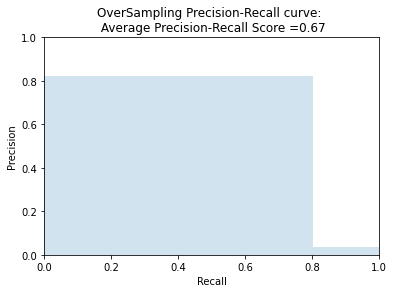

In [35]:
# Precision-Recall curve plot

y_score_rfc = best_est_rfc.predict(X_test)

precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_score_rfc)

plt.fill_between(recall_rfc, precision_rfc, step='post', alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_score(y_test, y_score_rfc), fontsize=15))

plt.show()

In [36]:
# provide the best parameters for the model
rand_rfc.best_params_

{'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 'sqrt',
 'random_state': 42}

# Gradient Boosting - XGBoost

In [37]:
import xgboost as xgb

In [55]:
accuracy_list_xgb = []
precision_list_xgb = []
recall_list_xgb = []
f1_list_xgb = []
auc_list_xgb = []

xgb_sm = xgb.XGBClassifier(random_state = 42)
xgb_params = {'eta' : [0.1,0.01,0.001],  # Learning rate
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2], # L2 regularization (higher values make model more conservative)
              'alpha' : [0,0.5,1]} # L1 regularization (higher values make model more conservative)
        
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4)

for train, val in sss.split(X_smote, y_smote):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) # SMOTE happens during Cross Validation not before..
    model_xgb = pipeline_xgb.fit(X_smote, y_smote)
    best_est_xgb = rand_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(X_smote[val])
    
    accuracy_list_xgb.append(pipeline_xgb.score(X_smote[val], y_smote[val]))
    precision_list_xgb.append(precision_score(y_smote[val], prediction_xgb))
    recall_list_xgb.append(recall_score(y_smote[val], prediction_xgb))
    f1_list_xgb.append(f1_score(y_smote[val], prediction_xgb))
    auc_list_xgb.append(roc_auc_score(y_smote[val], prediction_xgb))

print('(SMOTE) results:\n')
print("accuracy: ",np.mean(accuracy_list_xgb))
print("precision: ",np.mean(precision_list_xgb))
print("recall: ",np.mean(recall_list_xgb))
print("f1: ",np.mean(f1_list_xgb))


(SMOTE) results:

accuracy:  0.995736617716722
precision:  0.9924908424908425
recall:  0.9992417061611374
f1:  0.9958081043316256


In [59]:
# #predicting on the validation set using the smote sampling method
# smote_prediction_xgb = best_est_xgb.predict(X_test)
# print(classification_report(y_test, smote_prediction_xgb, target_names=label))

In [61]:
#Precision-Recall plot curve

# y_score_xgb = rand_xgb.best_estimator_.predict(X_test) 
# precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_score_xgb)
# plt.step(recall, precision, color='r', alpha=0.2,
#          where='post')
# plt.fill_between(recall_xgb,precision_xgb,step='post',alpha=0.2)
# plt.xlabel=('Recall')
# plt.ylabel=('Precision')
# plt.ylim([0.0,1.0])
# plt.xlim([0.0,1.0])
# plt.title('Oversampling Precision-Recall curve: \n Avg Precision-Recall Score\
# = {0:0.2f}'.format(average_precision_score(y_test,y_score_xgb)))
# plt.show()

In [63]:
#confusion_matrix(y_test,smote_prediction_xgb)

In [64]:
# provide the best parameters for the model
rand_xgb.best_params_

{'alpha': 0,
 'eta': 0.001,
 'eval_metric': 'logloss',
 'lambda': 1.5,
 'max_depth': 9}

# Extra Trees Classifier

In [42]:
#creating a list of metrics
from sklearn.ensemble import ExtraTreesClassifier

accuracy_list_ext = []
precision_list_ext = []
recall_list_ext = []
f1_list_ext = []
auc_list_ext = []

ext_sm = ExtraTreesClassifier(n_estimators=100, random_state=0)

ext_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}

In [43]:
#Using randomized search cross validation for the random forest classifier with 4 iterations

rand_ext = RandomizedSearchCV(ext_sm, ext_params,n_iter=4)

for train, val in sss.split(X_smote, y_smote):
    pipeline_ext = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_ext) # SMOTE happens during Cross Validation not before..
    model_ext = pipeline_ext.fit(X_smote, y_smote)
    best_est_ext = rand_ext.best_estimator_
    prediction_ext = best_est_ext.predict(X_smote[val])
    
    accuracy_list_ext.append(pipeline_ext.score(X_smote[val], y_smote[val]))
    precision_list_ext.append(precision_score(y_smote[val], prediction_ext))
    recall_list_ext.append(recall_score(y_smote[val], prediction_ext))
    f1_list_ext.append(f1_score(y_smote[val], prediction_ext))
    auc_list_ext.append(roc_auc_score(y_smote[val], prediction_ext))

print('(SMOTE) results:\n')    
print("accuracy: ", np.mean(accuracy_list_ext))
print("precision: ", np.mean(precision_list_ext))
print("recall: ",np.mean(recall_list_ext))
print("f1: ",np.mean(f1_list_ext))

(SMOTE) results:

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


Extra Trees Classifier seems to run significantly faster than Random Forest Classifier. In terms of computational cost, and therefore execution time, the Extra Trees algorithm is faster. This algorithm saves time because the whole procedure is the same, but it randomly chooses the split point and does not calculate the optimal one.

In [44]:
#predicting on the validation set using the smote sampling method
smote_prediction_ext = best_est_ext.predict(X_test)
print(classification_report(y_test, smote_prediction_ext, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.99      0.99      1313
Fin.Unstable       0.75      0.84      0.80        51

    accuracy                           0.98      1364
   macro avg       0.87      0.92      0.89      1364
weighted avg       0.98      0.98      0.98      1364



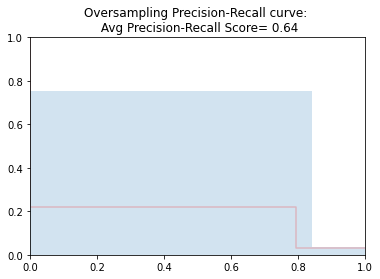

In [45]:
y_score_ext = rand_ext.best_estimator_.predict(X_test) 
precision_ext, recall_ext, _ = precision_recall_curve(y_test, y_score_ext)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_ext,precision_ext,step='post',alpha=0.2)
plt.xlabel=('Recall')
plt.ylabel=('Precision')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.title('Oversampling Precision-Recall curve: \n Avg Precision-Recall Score\
= {0:0.2f}'.format(average_precision_score(y_test,y_score_ext)))
plt.show()

In [54]:
confusion_matrix(y_test,smote_prediction_ext)

array([[1299,   14],
       [   8,   43]])

In [47]:
# provide the best parameters for the model
rand_ext.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'random_state': 42}

# Gradient Boosted Trees

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
accuracy_list_gbc = []
precision_list_gbc = []
recall_list_gbc = []
f1_list_gbc = []
auc_list_gbc = []

gbc_sm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
gbc_params = {}
        
rand_gbc = RandomizedSearchCV(gbc_sm, gbc_params, n_iter=4)

for train, val in sss.split(X_smote, y_smote):
    pipeline_gbc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_gbc) # SMOTE happens during Cross Validation not before..
    model_gbc = pipeline_gbc.fit(X_smote, y_smote)
    best_est_gbc = rand_gbc.best_estimator_
    prediction_gbc = best_est_gbc.predict(X_smote[val])
    
    accuracy_list_gbc.append(pipeline_gbc.score(X_smote[val], y_smote[val]))
    precision_list_gbc.append(precision_score(y_smote[val], prediction_gbc))
    recall_list_gbc.append(recall_score(y_smote[val], prediction_gbc))
    f1_list_gbc.append(f1_score(y_smote[val], prediction_gbc))
    auc_list_gbc.append(roc_auc_score(y_smote[val], prediction_gbc))

print('(SMOTE) results:\n')
print("accuracy: ",np.mean(accuracy_list_gbc))
print("precision: ",np.mean(precision_list_gbc))
print("recall: ",np.mean(recall_list_gbc))
print("f1: ",np.mean(f1_list_gbc))

(SMOTE) results:

accuracy:  0.9704497007019508
precision:  0.9603014944797847
recall:  0.9814372396955335
f1:  0.9707469148683942


In [50]:
#predicting on the validation set using the smote sampling method
smote_prediction_gbc = best_est_gbc.predict(X_test)
print(classification_report(y_test, smote_prediction_gbc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.95      0.97      1313
Fin.Unstable       0.36      0.75      0.48        51

    accuracy                           0.94      1364
   macro avg       0.67      0.85      0.73      1364
weighted avg       0.97      0.94      0.95      1364



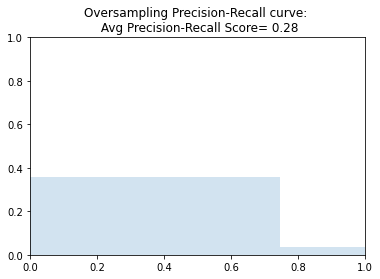

In [51]:
y_score_gbc = rand_gbc.best_estimator_.predict(X_test) 
precision_gbc, recall_gbc, _ = precision_recall_curve(y_test, y_score_gbc)

plt.fill_between(recall_gbc,precision_gbc,step='post',alpha=0.2)
plt.xlabel=('Recall')
plt.ylabel=('Precision')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.title('Oversampling Precision-Recall curve: \n Avg Precision-Recall Score\
= {0:0.2f}'.format(average_precision_score(y_test,y_score_gbc)))
plt.show()

In [52]:
confusion_matrix(y_test,smote_prediction_gbc)

array([[1245,   68],
       [  13,   38]])

In [53]:
# provide the best parameters for the model
rand_gbc.best_params_

{}